#Importing libraries and dependancies 

In [27]:
!pip install -r requirements.txt

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

#Load *MNISTmini* dataset

In [ ]:
# Load the full dataset again to ensure we have access to all samples
data_path = 'data/MNISTmini.mat'
mnist_data = loadmat(data_path)

# Extract all features and labels
train_features_full = mnist_data['train_fea1']
train_labels_full = mnist_data['train_gnd1'].flatten()
test_features_full = mnist_data['test_fea1']
test_labels_full = mnist_data['test_gnd1'].flatten()

# Combine to search for digits 2 and 3 across the entire dataset
all_features_full = np.vstack([train_features_full, test_features_full])
all_labels_full = np.hstack([train_labels_full, test_labels_full])

# Filter for digits 2 and 3
digit1, digit2 = 2, 3
mask = (all_labels_full == digit1) | (all_labels_full == digit2)
indices = np.where(mask)[0]

# Shuffle the indices to mix the classes
np.random.seed(42)  # Set seed for reproducibility
np.random.shuffle(indices)

# Select the first 3000 samples found
if len(indices) < 3000:
    print(f"Warning: Only found {len(indices)} samples for digits {digit1} and {digit2}")
    selected_indices = indices
else:
    selected_indices = indices[:3000]

selected_features = all_features_full[selected_indices]
selected_labels = all_labels_full[selected_indices]

X_train_binary_raw = selected_features[:1000]
y_train_binary_raw = selected_labels[:1000]

X_val_binary_raw = selected_features[1000:2000]
y_val_binary_raw = selected_labels[1000:2000]

X_test_binary_raw = selected_features[2000:3000]
y_test_binary_raw = selected_labels[2000:3000]

# Standardize features
scaler = StandardScaler()
X_train_binary = scaler.fit_transform(X_train_binary_raw)
X_val_binary = scaler.transform(X_val_binary_raw)
X_test_binary = scaler.transform(X_test_binary_raw)

# Relabel classes to 0 and 1 for binary classification
# digit 2 -> 0, digit 3 -> 1
y_train_binary = (y_train_binary_raw == digit2).astype(int)
y_val_binary = (y_val_binary_raw == digit2).astype(int)
y_test_binary = (y_test_binary_raw == digit2).astype(int)

print(f"Binary Classification (Digit {digit1} vs {digit2})")
print(f"Train shape: {X_train_binary.shape}, Class distribution: {np.bincount(y_train_binary)}")
print(f"Val shape: {X_val_binary.shape}, Class distribution: {np.bincount(y_val_binary)}")
print(f"Test shape: {X_test_binary.shape}, Class distribution: {np.bincount(y_test_binary)}")

Binary Classification (Digit 2 vs 3)
Train shape: (1000, 100), Class distribution: [460 540]
Val shape: (1000, 100), Class distribution: [518 482]
Test shape: (1000, 100), Class distribution: [506 494]


# Hyperparameter tuning: Train models with different C values

In [12]:
# Define range of C values (regularization hyperparameter)
# Lower C = stronger regularization, Higher C = weaker regularization
C_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Store errors for each C value
train_errors = []
val_errors = []

# Train and evaluate models for each C value
for C in C_values:
    # Train logistic regression model
    model = LogisticRegression(
        C=C,
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )
    model.fit(X_train_binary, y_train_binary)
    
    # Calculate training error
    y_train_pred = model.predict(X_train_binary)
    train_acc = accuracy_score(y_train_binary, y_train_pred)
    train_error = 1 - train_acc
    train_errors.append(train_error)
    
    # Calculate validation error
    y_val_pred = model.predict(X_val_binary)
    val_acc = accuracy_score(y_val_binary, y_val_pred)
    val_error = 1 - val_acc
    val_errors.append(val_error)
    
    print(f"C = {C:6.3f}: Train Error = {train_error:.4f}, Val Error = {val_error:.4f}")

# Find best C (lowest validation error)
best_idx = np.argmin(val_errors)
best_C = C_values[best_idx]
print(f"\nBest C value: {best_C} (validation error: {val_errors[best_idx]:.4f})")

C =  0.001: Train Error = 0.0500, Val Error = 0.0580
C =  0.010: Train Error = 0.0340, Val Error = 0.0350
C =  0.100: Train Error = 0.0190, Val Error = 0.0370
C =  1.000: Train Error = 0.0050, Val Error = 0.0440
C = 10.000: Train Error = 0.0000, Val Error = 0.0550
C = 100.000: Train Error = 0.0000, Val Error = 0.0620

Best C value: 0.01 (validation error: 0.0350)


# Plot training and validation errors vs C values

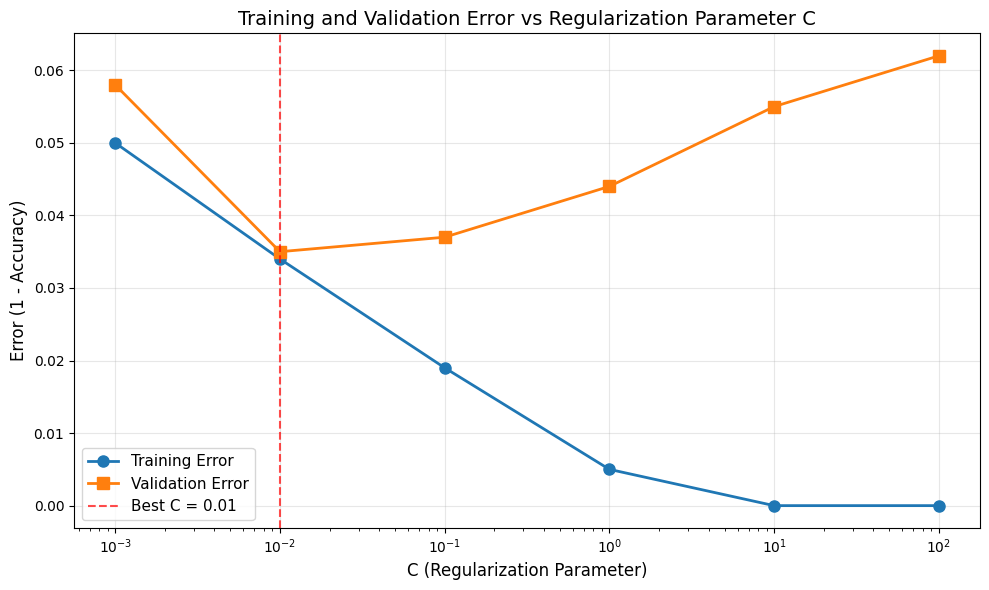

Training errors: ['0.0500', '0.0340', '0.0190', '0.0050', '0.0000', '0.0000']
Validation errors: ['0.0580', '0.0350', '0.0370', '0.0440', '0.0550', '0.0620']


In [13]:
# Plot training and validation errors
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_errors, 'o-', label='Training Error', linewidth=2, markersize=8)
plt.plot(C_values, val_errors, 's-', label='Validation Error', linewidth=2, markersize=8)

# Mark the best C value
plt.axvline(x=best_C, color='r', linestyle='--', alpha=0.7, label=f'Best C = {best_C}')

plt.xscale('log')  # Use log scale for C values
plt.xlabel('C (Regularization Parameter)', fontsize=12)
plt.ylabel('Error (1 - Accuracy)', fontsize=12)
plt.title('Training and Validation Error vs Regularization Parameter C', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary
print(f"Training errors: {[f'{e:.4f}' for e in train_errors]}")
print(f"Validation errors: {[f'{e:.4f}' for e in val_errors]}")

# Train final model with best C and evaluate on test set

In [26]:
# Train final model with best C value on training set
final_model = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
final_model.fit(X_train_binary, y_train_binary)

# Evaluate on test set
y_test_pred = final_model.predict(X_test_binary)
test_acc = accuracy_score(y_test_binary, y_test_pred)
test_error = 1 - test_acc

print(f"Final Model Performance:")
print(f"  Best C value: {best_C}")
print(f"  Training Error: {train_errors[best_idx]:.4f}")
print(f"  Validation Error: {val_errors[best_idx]:.4f}")
print(f"  Test Error: {test_error:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

# Confusion matrix for test set
cm = confusion_matrix(y_test_binary, y_test_pred)
print(f"\nConfusion Matrix (Test Set):")
print(f"                Predicted")
print(f"          _______2________3")
print(f"Actual 2  |    {cm[0][0]:5d}  {cm[0][1]:5d}")
print(f"       3  |    {cm[1][0]:5d}  {cm[1][1]:5d}")

Final Model Performance:
  Best C value: 0.01
  Training Error: 0.0340
  Validation Error: 0.0350
  Test Error: 0.0480
  Test Accuracy: 0.9520

Confusion Matrix (Test Set):
                Predicted
          _______2________3
Actual 2  |      487     19
       3  |       29    465
